|        |        |        |
|--------|--------|--------|
![H-BRS](logos/h-brs.png) | ![A2S](logos/a2s.png) | ![b-it](logos/b-it.png) |

# Autonomous Mobile Robots

# AMR Assignment 2

### General information

* Please do not add or delete any cells. Answers belong into the already provided cells (below the question).
* If a function is given (either as a signature or a full function), you should not change the name, arguments, or return value of the function.
* If you encounter empty cells underneath the answer that can not be edited, please ignore them; they are for testing purposes.
* Please note that variables declared in the notebook cells have global scope. To make sure your assignment works correctly as a whole, please restart the kernel and run all cells before submitting (e.g. via *Kernel -> Restart & Run All*).
* Code cells where you are supposed to give your answer often include the line  ```raise NotImplementedError```. This makes it easier to automatically grade answers. Once you fill out a function, please delete this line.

### Submission

Please make sure to write all your team members 2s IDs in the cell below before submission. Please submit your notebook via the JupyterHub web interface (in the main view -> Assignments -> Submit). If it is a group assignment, please make only one submission per group (for easier bookkeeping, it is best if this is always the same team member).

### Questions about the assignment

If you have questions about the assignment, you are encouraged to post them in the LEA forum. Proactive discussions lead to better understanding. Let's keep the forum active.

## Team members (2s IDs):

YOUR ANSWER HERE

* mmemon2s
* 
* 

# A. Multi-sensor Data Visualisation, Analysis, and Filtering [50 Points]

In this assignment, you will visualise the data from different sensors on the Robile; this includes 2D and 3D LiDARs, an IMU, and an RGB-D camera. You will particularly get accustomed to visualisation tools other than the standard ROS visualsation tool Rviz (in particular [`Foxglove`](https://foxglove.dev) and [`PlotJuggler`](https://github.com/facontidavide/PlotJuggler)), which you will use to detect some anomalies added to the LiDAR and RGB-D sensors, namely you will need to detect the approximate time or time range when these anomalies are introduced.

In addition, you will apply different filtering methods to the data, such as mean  and median filtering over the 2D LiDAR data and IMU data.

To work on this assignment, you need to download a ROS2 bag file that includes some data collected from the robot. The URL and password are as follows:
* Bag file (3.1GB): https://nx21454.your-storageshare.de/s/jfTkS9NLtG6gWGp
* Share password: `r0b!l3Rosbag?Da(ta*`

**Note:** As the ROS-related packages are not installed in the e2x Jupyter server, please **download this notebook and work on it locally**. Then, for submitting, update the code cells in this notebook (on the e2x server) and include appropriate plots with your submission. **Please do NOT upload the bag file with the submission**.

Let us first import all necessary packages. You can uncomment the desired packages and import any other required packages.

In [1]:
# Uncomment desired packages

import rclpy
import rosbag2_py
from rosbag2_py import StorageOptions, ConverterOptions, SequentialReader
import rosbags
from rosbags.serde import deserialize_cdr
from rosbags.rosbag2 import Reader
from rclpy.serialization import deserialize_message

from sensor_msgs.msg import LaserScan
from sensor_msgs.msg import PointCloud2
from sensor_msgs.msg import Image
from tf2_msgs.msg import TFMessage
from sensor_msgs.msg import Imu

import tf2_ros
import tf_transformations
from geometry_msgs.msg import Quaternion

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/ibhu/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## LiDAR visualisation [20 Points]

An anomaly is introduced by covering the LiDAR sensor by an opaque object, because of which we lose the laser scan data for approximately 2 seconds. Using the `Foxglove` visualisation tool, find the approximate time period in which the 2D LiDAR was covered. After visualising the data, please take a screenshot of it and upload the screenshot to the `img` directory. Then, embed the screenshot in the markdown cell below using:

```
![lidar_visualisation_screenshot](img/file_name.png)
```

where `file_name` is the image file name, and comment on the results.

**Notes:**
* In `Foxglove` you can directly upload the `.db3` rosbag file and use the different panel options to visualise the data.
* Due to the size of the data, it might not be possible to visualise all the data together in `Foxglove` based on your system configuration. Please thus only visualise the necessary data for the tasks. It is also recommended to download the tool locally instead of using the web application for better handling of large amounts of data.
* In `PlotJuggler`, you can upload the `.yaml` file located in the directory of the `.db3` bag file and select the topics to be visualised in the prompt that is displayed after selecting yaml file. The corresponding fields can then be dragged and dropped for visualisation.

YOUR ANSWER HERE

## Visualisation of 3D LiDAR data from a RoboSense LiDAR [10 Points]

Using `Foxglove`, take a screenshot of the 3D LiDAR data from the RoboSense at some arbitrary time instance and embed the image in the below cell.

![lidar_visualisation_screenshot](img/AMR_zero.png)

## RGB image visualisation [10 Points]

Take a screenshot of the visualisation tool where an image from the RealSense camera is visible and embed the image in the cell below.

**Hint:** You might take a look at different options under panel tab in `Foxglove`.

![lidar_visualisation_screenshot](img/AMR_Image.png)

## IMU data visualisation [10 Points]

To record the scenario of impact on the robot, it is "kicked" after it comes to a halt. Using the IMU readings, find the time instance at which the robot detects this impact. As before, find the approximate time period in which the impact was detected. After visualising the data, please take a screenshot of it and embed it in the cell below.

You can use either `Foxglove` or `PlotJuggler` to plot the IMU acceleraion readings. If you use `Foxglove`, it is helpful to simultaneously look at the robot moving and the corresponding IMU readings. A sample visualisation is shown below:

![imu-visualisation-sample](img/imu-visualisation-sample.png)

**Note**: Spikes in the IMU data are also caused by start of motion of the robot, so you should label the spikes in your screenshot accordingly.

![lidar_visualisation_screenshot](img/AMR_Robot_Kick.png)

# B. Filtering [50 Points]

As discussed in our lectures, sensor readings generally contain outliers and measurement noise. In this exercise, you will implement two data filtering techniques, namely mean and median filters, on the 2D LiDAR data and the IMU data.

As in the previous part, please work on your local machine, and then only copy your code and include any necessary screenshots in this notebook.

### Extraction of data from bag files [10 Points]

Before looking into these filters, we will extract the necessary data from the bag files. In the cell below, extract both 2D LiDAR data and IMU acceleration data from the bag file. In particular, read the 2D LiDAR data for a particular time instance closest to some user-specified time, and also read the full IMU data from the bag file.

In [12]:
# YOUR CODE HERE
import numpy as np
from rosbag2_py import SequentialReader, StorageOptions, ConverterOptions
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message

# --- Change this to your bag path ---
bag_path = "/home/ibhu/WS_2025_HBRS/AMR_ws25/amr_assignments_WS25/Assignment_2/bag/robile_bag_file.db3"

# Message types
LaserScan = get_message("sensor_msgs/msg/LaserScan")
Imu       = get_message("sensor_msgs/msg/Imu")

# --- Open rosbag ---
storage_options = StorageOptions(uri=bag_path, storage_id='sqlite3')  # or 'mcap' if your bag is MCAP
converter_options = ConverterOptions(input_serialization_format='cdr', output_serialization_format='cdr')

reader = SequentialReader()
reader.open(storage_options, converter_options)

# --- Empty lists for storing data ---
lidar_ranges = []
lidar_angles = []
imu_time = []
imu_ax, imu_ay, imu_az = [], [], []

start_time_ns = None

# --- Read all messages ---
while reader.has_next():
    topic, data, t_ns = reader.read_next()
    if start_time_ns is None:
        start_time_ns = t_ns
    t = (t_ns - start_time_ns) / 1e9  # relative time in seconds

    if topic == "/scan":
        msg = deserialize_message(data, LaserScan)
        angles = msg.angle_min + np.arange(len(msg.ranges)) * msg.angle_increment
        lidar_angles.append(angles)
        lidar_ranges.append(np.array(msg.ranges))
    elif topic == "/imu":
        msg = deserialize_message(data, Imu)
        imu_time.append(t)
        imu_ax.append(msg.linear_acceleration.x)
        imu_ay.append(msg.linear_acceleration.y)
        imu_az.append(msg.linear_acceleration.z)


lidar_ranges = np.array(lidar_ranges)
lidar_angles = np.array(lidar_angles)
imu_time = np.array(imu_time)
imu_ax = np.array(imu_ax)
imu_ay = np.array(imu_ay)
imu_az = np.array(imu_az)


print(f"/scan messages: {len(lidar_ranges)}, each with {lidar_ranges.shape[1]} points")
print(f"/imu messages: {len(imu_time)}, duration: {imu_time[-1]:.2f} s")
# raise NotImplementedError()

[INFO] [1761522138.881485680] [rosbag2_storage]: Opened database '/home/ibhu/WS_2025_HBRS/AMR_ws25/amr_assignments_WS25/Assignment_2/bag/robile_bag_file.db3' for READ_ONLY.


✅ Data loaded!
/scan messages: 362, each with 513 points
/imu messages: 29048, duration: 36.30 s



### Median filter of 2D LiDAR data [10 Points]

The idea behind a median filter is to use a sliding window of specific length in order to replace the central point in the window by the median of the points in the whole window. The median filter is a low-pass filter that removes outliers in the sensor data.

Your task is to apply the median filter on the 2D LiDAR data at a predefined time instance (you can experiment with the size of the sliding window). For this particular time instance, plot the `x` vs `y` coordinates of the 2D LiDAR data before and after applying the filter.

Please refer to this [wiki page](https://en.wikipedia.org/wiki/Median_filter) for an example of filtering 1D data.

**Note:** Please remember to include a title, grid, axes labels, and a legend in your plot.

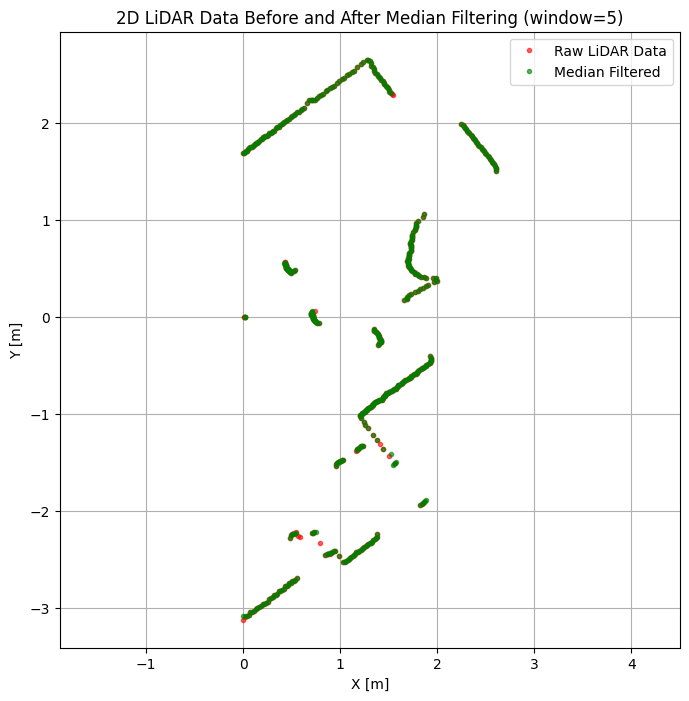

In [ ]:
# YOUR CODE HERE

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

scan_idx = 30  

ranges = lidar_ranges[scan_idx] # Get ranges for the selected scan
angles = lidar_angles[scan_idx] # Get angles for the selected scan

# --- Apply median filter ---
window_size = 5 # Define window size for median filter
ranges_filtered = medfilt(ranges, kernel_size=window_size) # Apply median filter

#polar to Cartesian ---
x_raw = ranges * np.cos(angles)
y_raw = ranges * np.sin(angles)

x_filt = ranges_filtered * np.cos(angles)
y_filt = ranges_filtered * np.sin(angles)

# --- Plot before and after filtering ---
plt.figure(figsize=(8, 8))
plt.plot(x_raw, y_raw, '.', color='red', alpha=0.6, label='Raw LiDAR Data')
plt.plot(x_filt, y_filt, '.', color='green', alpha=0.6, label='Median Filtered')

plt.title(f"2D LiDAR Data Before and After Median Filtering (window={window_size})")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()
# raise NotImplementedError()


### Median filtering of IMU data [10 Points]

Now, perform median filtering of the IMU acceleration over the y-axis. Then, plot the time vs. acceleration before and after filtering.

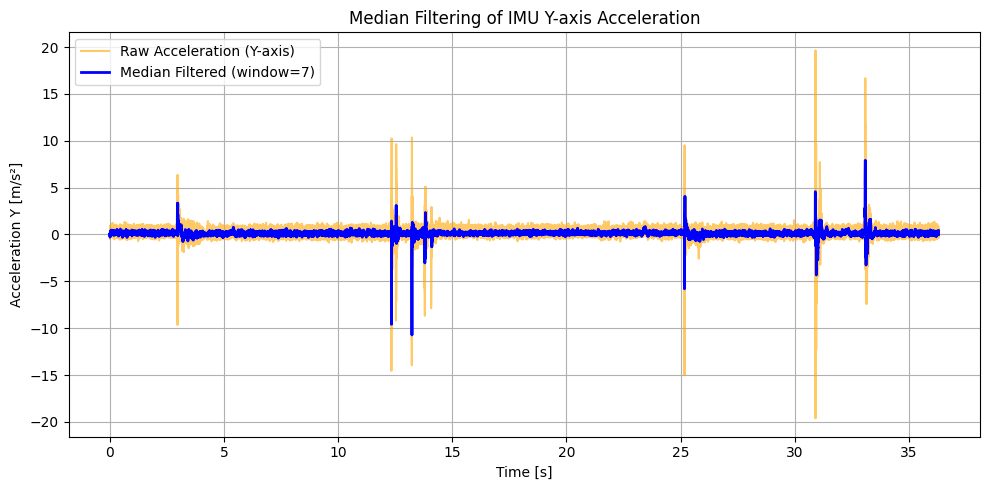

In [16]:
# YOUR CODE HERE

# --- Median filter parameters ---
window_size = 7

# --- Apply median filter to IMU Y-axis acceleration ---
imu_ay_filtered = medfilt(imu_ay, kernel_size=window_size)

# --- Plot before and after filtering ---
plt.figure(figsize=(10, 5))
plt.plot(imu_time, imu_ay, label='Raw Acceleration (Y-axis)', color='orange', alpha=0.6)
plt.plot(imu_time, imu_ay_filtered, label=f'Median Filtered (window={window_size})', color='blue', linewidth=2)

plt.title("Median Filtering of IMU Y-axis Acceleration")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration Y [m/s²]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# raise NotImplementedError()


### Mean filtering of 2D LiDAR data [10 Points]

The mean filter operates similarly to the median filter; however, the point under consideration is replaced by the mean of all points in the same window. This is generally used to smoothen the noise in the data rather than eliminate it fully.

Your task is to apply the mean filter on the 2D LiDAR data at the same time instance as before (again, you can experiment with the size of the sliding window). For this particular time instance, plot the `x` vs `y` coordinates of the 2D LiDAR data before and after applying the filter.

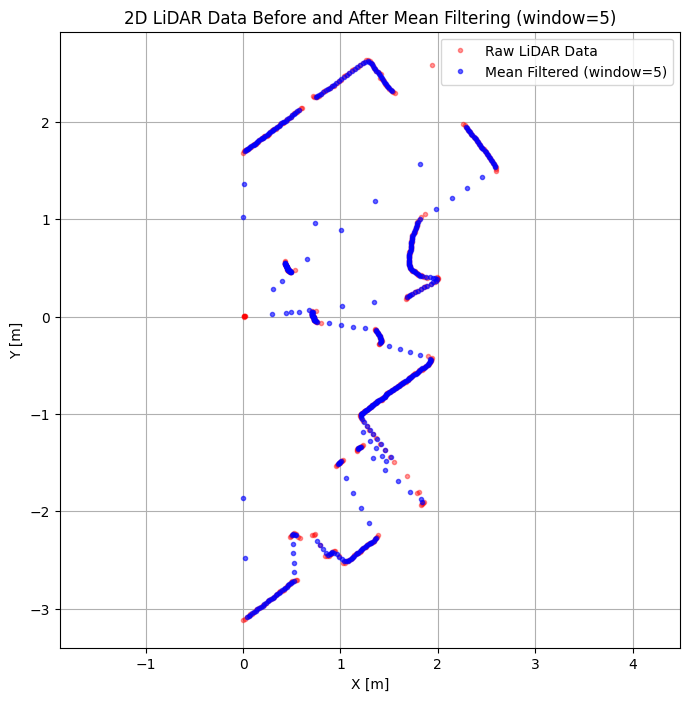

In [17]:
# YOUR CODE HERE
# --- Use the same LiDAR scan as before ---
scan_idx = 10
ranges = lidar_ranges[scan_idx]
angles = lidar_angles[scan_idx]

# --- Define window size for mean filter ---
window_size = 5   

# --- Apply mean (moving average) filter ---
# Create a simple moving average kernel and apply convolution
kernel = np.ones(window_size) / window_size
ranges_filtered = np.convolve(ranges, kernel, mode='same')

# --- Convert polar to Cartesian coordinates ---
x_raw = ranges * np.cos(angles)
y_raw = ranges * np.sin(angles)

x_filt = ranges_filtered * np.cos(angles)
y_filt = ranges_filtered * np.sin(angles)

# --- Plot before and after filtering ---
plt.figure(figsize=(8, 8))
plt.plot(x_raw, y_raw, '.', color='red', alpha=0.4, label='Raw LiDAR Data')
plt.plot(x_filt, y_filt, '.', color='blue', alpha=0.6, label=f'Mean Filtered (window={window_size})')

plt.title(f"2D LiDAR Data Before and After Mean Filtering (window={window_size})")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()
# raise NotImplementedError()


### Mean filtering of 2D IMU data [10 Points]

Finally, perform mean filtering of the IMU acceleration over the y-axis. Then, plot the time vs. acceleration before and after filtering.

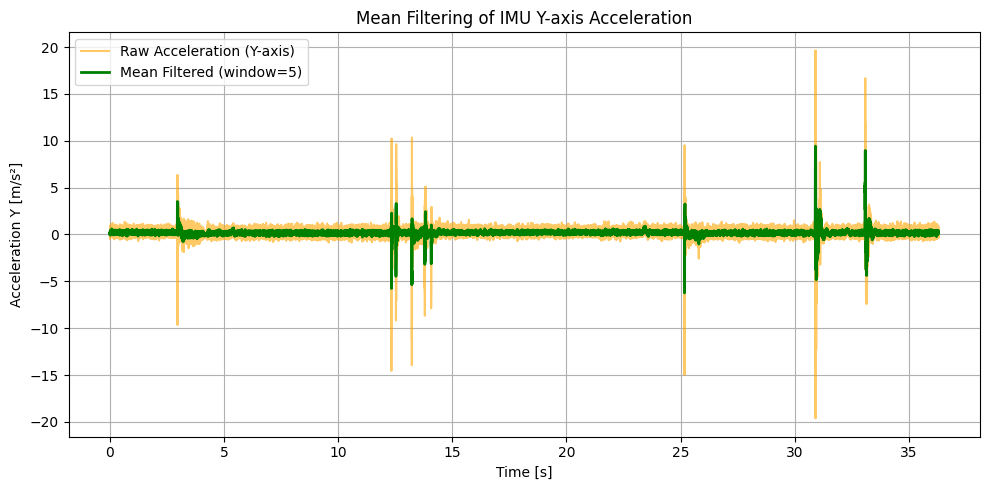

In [18]:
# YOUR CODE HERE

# --- Define mean filter window size ---
window_size = 5   


kernel = np.ones(window_size) / window_size
imu_ay_filtered_mean = np.convolve(imu_ay, kernel, mode='same')

# --- Plot before and after filtering ---
plt.figure(figsize=(10, 5))
plt.plot(imu_time, imu_ay, label='Raw Acceleration (Y-axis)', color='orange', alpha=0.6)
plt.plot(imu_time, imu_ay_filtered_mean, label=f'Mean Filtered (window={window_size})', color='green', linewidth=2)

plt.title("Mean Filtering of IMU Y-axis Acceleration")
plt.xlabel("Time [s]")
plt.ylabel("Acceleration Y [m/s²]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# raise NotImplementedError()